# Модуль 1, Спринт 3, Проект 3

Выполнил: Данила Козлов, студент 20 когорты дата-факультета яндекс практикума.


# Описание проекта

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

<a id="cell1"></a>
# Первичный осмотр данных

## Шаг 1. Откройте файл с данными и изучите общую информацию. <a id="cell1.1"></a>

In [65]:
!pip install seaborn -U

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.1)


In [66]:
import pandas as pd
import numpy as np
from IPython.display import display
from matplotlib import pyplot as plt
from scipy import stats as st
#import matplotlib.ticker as mtick
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [67]:
sns.__version__

'0.11.1'

Для начала загрузим наши таблички с данными.

## Таблица `users`

Таблица `users` (информация о пользователях):
* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

In [68]:
users = pd.read_csv('/datasets/users.csv')
display(users.sample(10, random_state = 42))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
361,1361,38,NaN,Екатеринбург,Рената,Кошелева,2018-09-09,ultra
73,1073,63,NaN,Владикавказ,Гордей,Павловский,2018-10-04,smart
374,1374,67,NaN,Махачкала,Леонид,Аркадьев,2018-04-01,smart
155,1155,71,NaN,Ставрополь,Александр,Чернов,2018-01-02,smart
104,1104,60,NaN,Нижний Тагил,Габриэль,Поляков,2018-02-21,ultra
394,1394,47,NaN,Орёл,Ксения,Жукова,2018-01-12,smart
377,1377,59,NaN,Брянск,Альфред,Семин,2018-02-25,ultra
124,1124,54,NaN,Махачкала,Альбин,Андрианов,2018-09-24,ultra
68,1068,34,NaN,Москва,Ким,Демьянов,2018-07-16,smart
450,1450,53,NaN,Москва,Алиса,Козлова,2018-10-10,smart


In [69]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Необходимо заменить формат столбца `reg_date` и `churn_date` с `object` на `datetime`

In [70]:
users.reg_date = pd.to_datetime(users.reg_date)
print(users.reg_date.dtypes)

datetime64[ns]


In [71]:
users.churn_date = pd.to_datetime(users.churn_date, errors = 'coerce')
print(users.churn_date.dtypes)
#display(users.churn_date)

datetime64[ns]


Видим, что у нас 500 пользователей, 38 из которых поменяли тариф.

## Таблица `calls`

Таблица `calls` (информация о звонках):
* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [72]:
calls = pd.read_csv('/datasets/calls.csv')
display(calls.sample(10, random_state = 42))

,id,call_date,duration,user_id
158741,1392_406,2018-07-09,4.94,1392
95947,1244_202,2018-11-09,0.00,1244
10624,1027_494,2018-10-07,3.10,1027
167423,1412_340,2018-09-25,5.91,1412
73194,1184_168,2018-09-03,9.86,1184
176140,1435_58,2018-12-21,2.31,1435
41601,1102_28,2018-09-21,2.44,1102
124173,1319_322,2018-12-28,16.24,1319
19027,1052_176,2018-11-11,15.55,1052
188175,1464_695,2018-09-01,0.00,1464


In [73]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB



Из таблицы видно, что столбец `call_date` имеет неправильный формат object, необходимо его поменять на формат `DateTime`

Что ещё хорошо, то что нет пропущенных значений в табличке.

In [74]:
calls.call_date = pd.to_datetime(calls.call_date)
print(calls.call_date.dtypes)

datetime64[ns]


**Обратите внимание:** «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.

Поэтому округлим сразу длительность минут до верхних значений.

In [75]:
calls.duration = calls.duration.apply(np.ceil).astype('int')
print(sorted(calls.duration.unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]


Как видно из массива выше, то мы получили округленные значения до целых минут сверху и максимальная продолжительность разговора 38 минут.

## Таблица `internet`

Таблица `internet` (информация об интернет-сессиях):
* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [76]:
internet = pd.read_csv('/datasets/internet.csv')

In [77]:
display(internet.sample(10, random_state = 42))

,Unnamed: 0,id,mb_used,session_date,user_id
31737,31737,1110_331,351.71,2018-09-04,1110
31333,31333,1109_399,257.69,2018-06-09,1109
61121,61121,1207_191,128.18,2018-11-05,1207
71184,71184,1241_88,736.71,2018-11-23,1241
84394,84394,1286_76,900.69,2018-12-18,1286
146984,146984,1491_256,464.64,2018-07-31,1491
32352,32352,1113_196,72.39,2018-11-04,1113
103524,103524,1349_40,779.95,2018-12-23,1349
26570,26570,1092_236,229.27,2018-11-17,1092
9728,9728,1033_108,457.25,2018-08-11,1033


In [78]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


По таблице видно, что появился какой-то странный столбец `Unnamed: 0`, который полностью совпадает с индексом, Так что просто удалим его.  
Также заменим формат столбца `session_date` на DateTime
Ну и можно заметить, что информации меньше на 50+ тысяч записей, чем в звонках.

In [79]:
internet.session_date = pd.to_datetime(internet.session_date)
print(internet.session_date.dtypes)

datetime64[ns]


In [80]:
internet.drop(columns = 'Unnamed: 0', inplace = True)
internet.columns

Index(['id', 'mb_used', 'session_date', 'user_id'], dtype='object')

<font color='brown'>В случае с мегабайтами округление не так критично, но тоже не помешает.

## Таблица `messages`

Таблица `messages` (информация о сообщениях):
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

In [81]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.sample(10, random_state = 42))

,id,message_date,user_id
8581,1033_332,2018-11-08,1033
12476,1054_32,2018-08-10,1054
14805,1065_141,2018-05-29,1065
118278,1481_49,2018-05-24,1481
23803,1099_10,2018-08-24,1099
93256,1383_7,2018-11-04,1383
81126,1340_100,2018-07-01,1340
41780,1178_3,2018-06-09,1178
73875,1311_284,2018-10-03,1311
118967,1482_529,2018-09-24,1482


In [82]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Так же необходимо заменить формат `на datetime` в столбце `message_date` 

In [83]:
messages.message_date = pd.to_datetime(messages.message_date)
print(messages.message_date.dtypes)

datetime64[ns]


## Таблица `tariffs`

Таблица `tariffs` (информация о тарифах):
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [84]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
#display(tariffs.sample(10, random_state = 42))
tariffs.head(10)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [85]:
30720 / 1024

30.0

# Расчет характеристик для пользователей

Посчитайте для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

## Расчет потраченных минут по месяцам

In [86]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.



Посмотрим сколько у нас записей в датасете, где продолжительность звонка 0.00

In [87]:
print('Количество пустых звонков:', len(calls.query('duration == 0.00')))
print(f"Доля пустых звонков: {(calls.duration == 0.00).mean():0.2%}")

Количество пустых звонков: 39613
Доля пустых звонков: 19.55%


In [88]:
calls.duration.describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

In [89]:
calls.query('duration < 1').duration.unique()

array([0])

In [90]:
len(calls)

202607

<font color=brown>Полезные цифры, но нам нужно принять какое-то решение по нулевым звонкам. Можем ли мы их удалить? Или проще оставить и игнорировать?

Для начала я добавлю в эту таблицу параметр `month`, чтобы потом сделать расчет по тарифам. 

In [91]:
calls['call_month'] = calls['call_date'].values.astype('datetime64[M]')
calls.head()

,id,call_date,duration,user_id,call_month
0,1000_0,2018-07-25,0,1000,2018-07-01
1,1000_1,2018-08-17,0,1000,2018-08-01
2,1000_2,2018-06-11,3,1000,2018-06-01
3,1000_3,2018-09-21,14,1000,2018-09-01
4,1000_4,2018-12-15,6,1000,2018-12-01


In [92]:
calls.groupby(['user_id', 'call_month']).duration.agg(['count','sum']).reset_index()#.rename(columns = {'duration': 'total_min'})

,user_id,call_month,count,sum
0,1000,2018-05-01,22,159
1,1000,2018-06-01,43,172
2,1000,2018-07-01,47,340
3,1000,2018-08-01,52,408
4,1000,2018-09-01,58,466
...,...,...,...,...
3169,1498,2018-10-01,41,247
3170,1499,2018-09-01,9,70
3171,1499,2018-10-01,68,449
3172,1499,2018-11-01,74,612


In [93]:
df1 = calls.pivot_table(index = ['user_id', 'call_month'], values = 'duration', aggfunc = ['count','sum'])
df1.columns = ['count','total_min']

In [94]:
df1.head(15)

count  total_min
user_id call_month                  
1000    2018-05-01     22        159
        2018-06-01     43        172
        2018-07-01     47        340
        2018-08-01     52        408
        2018-09-01     58        466
        2018-10-01     57        350
        2018-11-01     43        338
        2018-12-01     46        333
1001    2018-11-01     59        430
        2018-12-01     63        414
1002    2018-06-01     15        117
        2018-07-01     26        214
        2018-08-01     42        289
        2018-09-01     36        206
        2018-10-01     33        212

In [95]:
zero_calls = calls[calls.duration == 0.0].groupby(['user_id', 'call_month']).duration.count()
zero_calls.head(15)

user_id  call_month
1000     2018-05-01     5
         2018-06-01    15
         2018-07-01     6
         2018-08-01    10
         2018-09-01    12
         2018-10-01    13
         2018-11-01     6
         2018-12-01     8
1001     2018-11-01    14
         2018-12-01    16
1002     2018-06-01     1
         2018-07-01     5
         2018-08-01     5
         2018-09-01    11
         2018-10-01     9
Name: duration, dtype: int64

In [96]:
zero_calls.fillna(0)

user_id  call_month
1000     2018-05-01     5
         2018-06-01    15
         2018-07-01     6
         2018-08-01    10
         2018-09-01    12
                       ..
1498     2018-10-01    11
1499     2018-09-01     1
         2018-10-01    24
         2018-11-01    12
         2018-12-01    13
Name: duration, Length: 3119, dtype: int64

In [97]:
df1['num_zero_calls'] = zero_calls

df1.num_zero_calls = df1.num_zero_calls.fillna(0).astype(int)

In [98]:
df1.num_zero_calls.isna().sum()

0

In [99]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3174 entries, (1000, 2018-05-01 00:00:00) to (1499, 2018-12-01 00:00:00)
Data columns (total 3 columns):
count             3174 non-null int64
total_min         3174 non-null int64
num_zero_calls    3174 non-null int64
dtypes: int64(3)
memory usage: 87.7 KB


In [100]:
df1 = df1.reset_index().merge(users[['user_id','tariff']], on = 'user_id').rename(columns = {'count': 'num_calls', 'tariff': 'tariff_name'})

In [101]:
df1 = df1.merge(tariffs[['minutes_included','rub_per_minute','tariff_name']], on = 'tariff_name')

In [102]:
df1['overdraft_minutes'] = df1.total_min - df1.minutes_included

In [103]:
df1['calls_fee'] = df1.apply(lambda row: row['overdraft_minutes'] * row['rub_per_minute'] if row['overdraft_minutes'] > 0 else 0, axis = 1)

In [104]:
df1.sample(15)

,user_id,call_month,num_calls,total_min,num_zero_calls,tariff_name,minutes_included,rub_per_minute,overdraft_minutes,calls_fee
2840,1426,2018-12-01,74,637,10,smart,500,3,137,411
1557,1134,2018-05-01,66,385,16,smart,500,3,-115,0
2045,1237,2018-11-01,65,415,10,smart,500,3,-85,0
1903,1204,2018-11-01,39,239,14,smart,500,3,-261,0
1004,1010,2018-09-01,29,142,11,smart,500,3,-358,0
1189,1051,2018-10-01,16,123,1,smart,500,3,-377,0
2953,1451,2018-09-01,122,843,25,smart,500,3,343,1029
2412,1320,2018-12-01,59,429,9,smart,500,3,-71,0
1740,1173,2018-09-01,74,484,17,smart,500,3,-16,0
1777,1177,2018-07-01,60,454,14,smart,500,3,-46,0


Такс, тариф прицепил к табличке, так что теперь осталось добавить количество минут в тарифе и потом вычислить.
Также хорошо бы не забыть посмотреть данные с теми пользователями, которые закончили использовать тариф.
Видимо записи после даты прекращения тарифа лучше вообще не использовать.


## Расчет потраченных сообщений по месяцам

Посчитать количество отправленных сообщений по месяцам;

In [105]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [106]:
messages['message_month'] = messages['message_date'].values.astype('datetime64[M]')
messages.head()

,id,message_date,user_id,message_month
0,1000_0,2018-06-27,1000,2018-06-01
1,1000_1,2018-10-08,1000,2018-10-01
2,1000_2,2018-08-04,1000,2018-08-01
3,1000_3,2018-06-16,1000,2018-06-01
4,1000_4,2018-12-05,1000,2018-12-01


In [107]:
df2 = messages.groupby(['user_id', 'message_month']).id.agg('count').reset_index().rename(columns = {'id': 'total_sms'})

In [108]:
df2 = df2.merge(users[['user_id','tariff']], on = 'user_id').rename(columns = {'tariff': 'tariff_name'})

In [109]:
df2 = df2.merge(tariffs[['messages_included','rub_per_message','tariff_name']], on = 'tariff_name')

In [110]:
df2['overdraft_messages'] = df2.total_sms - df2.messages_included

In [111]:
df2['messages_fee'] = df2.apply(lambda row: row['overdraft_messages'] * row['rub_per_message'] if row['overdraft_messages'] > 0 else 0, axis = 1)

In [112]:
df2.sample(15)

,user_id,message_month,total_sms,tariff_name,messages_included,rub_per_message,overdraft_messages,messages_fee
2129,1351,2018-11-01,5,smart,50,3,-45,0
390,1300,2018-10-01,191,ultra,1000,1,-809,0
569,1380,2018-12-01,30,ultra,1000,1,-970,0
1116,1072,2018-11-01,25,smart,50,3,-25,0
1594,1199,2018-09-01,44,smart,50,3,-6,0
2173,1362,2018-11-01,10,smart,50,3,-40,0
2059,1324,2018-12-01,125,smart,50,3,75,225
737,1458,2018-04-01,4,ultra,1000,1,-996,0
984,1046,2018-08-01,13,smart,50,3,-37,0
90,1081,2018-07-01,18,ultra,1000,1,-982,0


## Расчет потраченных гигабайт по месяцам

In [113]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [114]:
internet['session_month'] = internet['session_date'].values.astype('datetime64[M]')
internet.head()

,id,mb_used,session_date,user_id,session_month
0,1000_0,112.95,2018-11-25,1000,2018-11-01
1,1000_1,1052.81,2018-09-07,1000,2018-09-01
2,1000_2,1197.26,2018-06-25,1000,2018-06-01
3,1000_3,550.27,2018-08-22,1000,2018-08-01
4,1000_4,302.56,2018-09-24,1000,2018-09-01


In [115]:
df3 = internet.groupby(['user_id', 'session_month']).mb_used.sum().reset_index().rename(columns = {'mb_used': 'total_mb'})

In [116]:
df3 = df3.merge(users[['user_id','tariff']], on = 'user_id').rename(columns = {'tariff': 'tariff_name'})

In [117]:
df3 = df3.merge(tariffs[['mb_per_month_included','rub_per_gb','tariff_name']], on = 'tariff_name')

In [118]:
df3['overdraft_mb'] = df3.total_mb - df3.mb_per_month_included

In [119]:
df3['overdraft_gb'] = np.ceil(df3.overdraft_mb / 1024).astype(int)

Округлил количество мегабайт до полных гигабайт, чтобы посчитать задолженности при превышении

In [120]:
df3['internet_fee'] = df3.apply(lambda row: row['overdraft_gb'] * row['rub_per_gb'] if row['overdraft_gb'] > 0 else 0, axis = 1)

In [121]:
df3.sample(15)

,user_id,session_month,total_mb,tariff_name,mb_per_month_included,rub_per_gb,overdraft_mb,overdraft_gb,internet_fee
546,1310,2018-09-01,15677.46,ultra,30720,150,-15042.54,-14,0
2965,1448,2018-11-01,21231.85,smart,15360,200,5871.85,6,1200
2148,1251,2018-08-01,23750.85,smart,15360,200,8390.85,9,1800
2859,1425,2018-10-01,12279.28,smart,15360,200,-3080.72,-3,0
2603,1370,2018-06-01,17969.97,smart,15360,200,2609.97,3,600
3087,1477,2018-12-01,20606.69,smart,15360,200,5246.69,6,1200
1245,1056,2018-07-01,14360.51,smart,15360,200,-999.49,0,0
2138,1250,2018-09-01,12115.82,smart,15360,200,-3244.18,-3,0
2793,1413,2018-08-01,8760.97,smart,15360,200,-6599.03,-6,0
876,1453,2018-02-01,21470.29,ultra,30720,150,-9249.71,-9,0


## Вывод:

По итогу имеем 3 таблички `df1`, `df2`, `df3` которые содержат информацию по тратам в месяц по звонкам, сообщениям и интернету соответственно. Теперь необходимо объединить таблички в одну общую по пользователю, по месяцам, имя тарифа, стоимость тарифа, превышение по тарифу в месяц по всем трем параметрам. 

In [122]:
print('Длина датасета df1:',len(df1))
print('Длина датасета df2:',len(df2))
print('Длина датасета df3:',len(df3))

Длина датасета df1: 3174
Длина датасета df2: 2717
Длина датасета df3: 3203


Самый большой датасет у нас оказался с информацией по интернету, так что если при соединении строчек окажется меньше, то точно нужно искать ошибку.
Теперь вопрос как мне соединить их все и ничего не потерять, записи ведь могут быть разные, если человек не совершил ни одного звонка или не отправил ни одного сообщения...  

In [123]:
display(df1.head(10))
display(df2.head(10))
display(df3.head(10))

,user_id,call_month,num_calls,total_min,num_zero_calls,tariff_name,minutes_included,rub_per_minute,overdraft_minutes,calls_fee
0,1000,2018-05-01,22,159,5,ultra,3000,1,-2841,0
1,1000,2018-06-01,43,172,15,ultra,3000,1,-2828,0
2,1000,2018-07-01,47,340,6,ultra,3000,1,-2660,0
3,1000,2018-08-01,52,408,10,ultra,3000,1,-2592,0
4,1000,2018-09-01,58,466,12,ultra,3000,1,-2534,0
5,1000,2018-10-01,57,350,13,ultra,3000,1,-2650,0
6,1000,2018-11-01,43,338,6,ultra,3000,1,-2662,0
7,1000,2018-12-01,46,333,8,ultra,3000,1,-2667,0
8,1003,2018-08-01,55,380,12,ultra,3000,1,-2620,0
9,1003,2018-09-01,134,961,29,ultra,3000,1,-2039,0


,user_id,message_month,total_sms,tariff_name,messages_included,rub_per_message,overdraft_messages,messages_fee
0,1000,2018-05-01,22,ultra,1000,1,-978,0
1,1000,2018-06-01,60,ultra,1000,1,-940,0
2,1000,2018-07-01,75,ultra,1000,1,-925,0
3,1000,2018-08-01,81,ultra,1000,1,-919,0
4,1000,2018-09-01,57,ultra,1000,1,-943,0
5,1000,2018-10-01,73,ultra,1000,1,-927,0
6,1000,2018-11-01,58,ultra,1000,1,-942,0
7,1000,2018-12-01,70,ultra,1000,1,-930,0
8,1003,2018-08-01,37,ultra,1000,1,-963,0
9,1003,2018-09-01,91,ultra,1000,1,-909,0


,user_id,session_month,total_mb,tariff_name,mb_per_month_included,rub_per_gb,overdraft_mb,overdraft_gb,internet_fee
0,1000,2018-05-01,2253.49,ultra,30720,150,-28466.51,-27,0
1,1000,2018-06-01,23233.77,ultra,30720,150,-7486.23,-7,0
2,1000,2018-07-01,14003.64,ultra,30720,150,-16716.36,-16,0
3,1000,2018-08-01,14055.93,ultra,30720,150,-16664.07,-16,0
4,1000,2018-09-01,14568.91,ultra,30720,150,-16151.09,-15,0
5,1000,2018-10-01,14702.49,ultra,30720,150,-16017.51,-15,0
6,1000,2018-11-01,14756.47,ultra,30720,150,-15963.53,-15,0
7,1000,2018-12-01,9817.61,ultra,30720,150,-20902.39,-20,0
8,1003,2018-08-01,8565.21,ultra,30720,150,-22154.79,-21,0
9,1003,2018-09-01,12468.87,ultra,30720,150,-18251.13,-17,0


In [124]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Скорее всего потребуется прочная основа на которую клеить все можно. Создам я табличку по месяцам 

In [126]:
r = df1[['user_id','call_month','tariff_name','num_calls','total_min','calls_fee']].merge(df2[['user_id','message_month','tariff_name','total_sms','messages_fee']], 
                                                                                      how = 'outer', 
                                                                                      left_on = ['user_id','call_month','tariff_name'], 
                                                                                      right_on = ['user_id','message_month','tariff_name'])

r = r.merge(df3[['user_id','session_month','tariff_name','overdraft_gb','internet_fee']], 
                                                                                      how = 'outer', 
                                                                                      left_on = ['user_id','call_month','tariff_name'], 
                                                                                      right_on = ['user_id','session_month','tariff_name'])

r

,user_id,call_month,tariff_name,num_calls,total_min,calls_fee,message_month,total_sms,messages_fee,session_month,overdraft_gb,internet_fee
0,1000,2018-05-01,ultra,22.0,159.0,0.0,2018-05-01,22.0,0.0,2018-05-01,-27.0,0.0
1,1000,2018-06-01,ultra,43.0,172.0,0.0,2018-06-01,60.0,0.0,2018-06-01,-7.0,0.0
2,1000,2018-07-01,ultra,47.0,340.0,0.0,2018-07-01,75.0,0.0,2018-07-01,-16.0,0.0
3,1000,2018-08-01,ultra,52.0,408.0,0.0,2018-08-01,81.0,0.0,2018-08-01,-16.0,0.0
4,1000,2018-09-01,ultra,58.0,466.0,0.0,2018-09-01,57.0,0.0,2018-09-01,-15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3248,1489,NaT,smart,NaN,NaN,NaN,NaT,NaN,NaN,2018-08-01,-4.0,0.0
3249,1489,NaT,smart,NaN,NaN,NaN,NaT,NaN,NaN,2018-09-01,2.0,400.0
3250,1489,NaT,smart,NaN,NaN,NaN,NaT,NaN,NaN,2018-10-01,5.0,1000.0
3251,1489,NaT,smart,NaN,NaN,NaN,NaT,NaN,NaN,2018-11-01,3.0,600.0


## Создание общей таблички

In [127]:
users['reg_month'] = users['reg_date'].values.astype('datetime64[M]')
users['churn_month'] = users['churn_date'].values.astype('datetime64[M]')
min_month = users.reg_month.min()
max_month = users.reg_month.max()
print(min_month, max_month)

2018-01-01 00:00:00 2018-12-01 00:00:00


Получили, что у нас выборка по времени только в течение года.

In [128]:
dr = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
dr.columns = ['month']

In [129]:
dr

,month
0,2018-01-01
1,2018-02-01
2,2018-03-01
3,2018-04-01
4,2018-05-01
5,2018-06-01
6,2018-07-01
7,2018-08-01
8,2018-09-01
9,2018-10-01


In [130]:
user = users[['user_id','reg_month','churn_month']]
user.head()

,user_id,reg_month,churn_month
0,1000,2018-05-01,NaT
1,1001,2018-11-01,NaT
2,1002,2018-06-01,NaT
3,1003,2018-08-01,NaT
4,1004,2018-05-01,NaT


Теперь я сделаю кроссджойн, чтобы создать период за который каждый юзер был активен или нет.

In [131]:
len(user)*len(dr)

6000

В целом получили ожидаемое количество строк, период 12 месяцев и 500 пользователей, так что все хорошо ровно 6000 и должно получиться.

In [132]:
user['key'] = 1
dr['key'] = 1

In [133]:
report = dr.merge(user, on = 'key')

In [134]:
print(len(report))
report.head(12)

6000


,month,key,user_id,reg_month,churn_month
0,2018-01-01,1,1000,2018-05-01,NaT
1,2018-01-01,1,1001,2018-11-01,NaT
2,2018-01-01,1,1002,2018-06-01,NaT
3,2018-01-01,1,1003,2018-08-01,NaT
4,2018-01-01,1,1004,2018-05-01,NaT
5,2018-01-01,1,1005,2018-01-01,NaT
6,2018-01-01,1,1006,2018-02-01,NaT
7,2018-01-01,1,1007,2018-04-01,NaT
8,2018-01-01,1,1008,2018-12-01,NaT
9,2018-01-01,1,1009,2018-03-01,NaT


Теперь удалим лишние строчки, когда пользователь ещё не был зарегистрирован, и те строчки, когда пользователь прекратил пользоваться тарифом (там 38 таких пользователей).

In [135]:
report = report[report.month >= report.reg_month]
len(report)

3259

Перед тем как избавиться от строк, в которых пользователи прекратили пользоваться тарифами необходимо заполнить значения в churn_month на максимальный месяц нашей выборки

In [136]:
report.churn_month = report.churn_month.fillna(max_month)

In [137]:
report = report[report.churn_month >= report.month]

In [138]:
len(report)

3216

Взглянем на отдельного пользователя

In [139]:
report[report.user_id == 1002]

,month,key,user_id,reg_month,churn_month
2502,2018-06-01,1,1002,2018-06-01,2018-12-01
3002,2018-07-01,1,1002,2018-06-01,2018-12-01
3502,2018-08-01,1,1002,2018-06-01,2018-12-01
4002,2018-09-01,1,1002,2018-06-01,2018-12-01
4502,2018-10-01,1,1002,2018-06-01,2018-12-01
5002,2018-11-01,1,1002,2018-06-01,2018-12-01
5502,2018-12-01,1,1002,2018-06-01,2018-12-01


Теперь у нас есть необходимое основание, на которое можно крепить данные из наших сводных табличкек.
Теперь точно ничего не потеряем в случае если пользователь не был активен в интернете, звонках или сообщениях, за те месяца будут просто стоять NaN. К тому же можем ориентироваться на число 3216 строк после присоединения табличек. 

Вопрос только как правильно соединить таблички по user_id и month. Это точно должен быть left join к таблице report.

In [140]:
df1.sample()

,user_id,call_month,num_calls,total_min,num_zero_calls,tariff_name,minutes_included,rub_per_minute,overdraft_minutes,calls_fee
206,1120,2018-11-01,36,310,2,ultra,3000,1,-2690,0


In [141]:
report.merge(df1[['user_id','call_month','tariff_name','total_min','overdraft_minutes','calls_fee']], how = 'left', left_on = ['user_id', 'month'], right_on = ['user_id', 'call_month']).sort_values('user_id')

,month,key,user_id,reg_month,churn_month,call_month,tariff_name,total_min,overdraft_minutes,calls_fee
1154,2018-08-01,1,1000,2018-05-01,2018-12-01,2018-08-01,ultra,408.0,-2592.0,0.0
2288,2018-11-01,1,1000,2018-05-01,2018-12-01,2018-11-01,ultra,338.0,-2662.0,0.0
1871,2018-10-01,1,1000,2018-05-01,2018-12-01,2018-10-01,ultra,350.0,-2650.0,0.0
614,2018-06-01,1,1000,2018-05-01,2018-12-01,2018-06-01,ultra,172.0,-2828.0,0.0
1496,2018-09-01,1,1000,2018-05-01,2018-12-01,2018-09-01,ultra,466.0,-2534.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1153,2018-07-01,1,1498,2018-07-01,2018-10-01,2018-07-01,smart,175.0,-325.0,0.0
2737,2018-11-01,1,1499,2018-09-01,2018-12-01,2018-11-01,smart,612.0,112.0,336.0
1870,2018-09-01,1,1499,2018-09-01,2018-12-01,2018-09-01,smart,70.0,-430.0,0.0
2287,2018-10-01,1,1499,2018-09-01,2018-12-01,2018-10-01,smart,449.0,-51.0,0.0


Видно, что соединение произошло успешно, мы ничего не потеряли по дороге, так как длина осталась прежней 3216 строк.

Теперь заменим таблицу report этой таблицей, затем присоединим оставшиеся две таблички.  
А после удалим лишние столбцы, которые не понадобятся нам в общей таблице.

In [142]:
report = report.merge(df1[['user_id','call_month','tariff_name','total_min','overdraft_minutes','calls_fee']], how = 'left', left_on = ['user_id', 'month'], right_on = ['user_id', 'call_month']).sort_values('user_id')

In [143]:
df2.sample()

,user_id,message_month,total_sms,tariff_name,messages_included,rub_per_message,overdraft_messages,messages_fee
1368,1145,2018-07-01,111,smart,50,3,61,183


In [144]:
report = report.merge(df2[['user_id','message_month','total_sms','overdraft_messages','messages_fee']], how = 'left', left_on = ['user_id', 'month'], right_on = ['user_id', 'message_month'])

In [145]:
df3.sample()

,user_id,session_month,total_mb,tariff_name,mb_per_month_included,rub_per_gb,overdraft_mb,overdraft_gb,internet_fee
343,1200,2018-08-01,16303.33,ultra,30720,150,-14416.67,-14,0


In [146]:
report = report.merge(df3[['user_id','session_month','total_mb','overdraft_gb','internet_fee']], how = 'left', left_on = ['user_id', 'month'], right_on = ['user_id', 'session_month'])

In [147]:
report.head(15)

,month,key,user_id,reg_month,churn_month,call_month,tariff_name,total_min,overdraft_minutes,calls_fee,message_month,total_sms,overdraft_messages,messages_fee,session_month,total_mb,overdraft_gb,internet_fee
0,2018-08-01,1,1000,2018-05-01,2018-12-01,2018-08-01,ultra,408.0,-2592.0,0.0,2018-08-01,81.0,-919.0,0.0,2018-08-01,14055.93,-16.0,0.0
1,2018-11-01,1,1000,2018-05-01,2018-12-01,2018-11-01,ultra,338.0,-2662.0,0.0,2018-11-01,58.0,-942.0,0.0,2018-11-01,14756.47,-15.0,0.0
2,2018-10-01,1,1000,2018-05-01,2018-12-01,2018-10-01,ultra,350.0,-2650.0,0.0,2018-10-01,73.0,-927.0,0.0,2018-10-01,14702.49,-15.0,0.0
3,2018-06-01,1,1000,2018-05-01,2018-12-01,2018-06-01,ultra,172.0,-2828.0,0.0,2018-06-01,60.0,-940.0,0.0,2018-06-01,23233.77,-7.0,0.0
4,2018-09-01,1,1000,2018-05-01,2018-12-01,2018-09-01,ultra,466.0,-2534.0,0.0,2018-09-01,57.0,-943.0,0.0,2018-09-01,14568.91,-15.0,0.0
5,2018-07-01,1,1000,2018-05-01,2018-12-01,2018-07-01,ultra,340.0,-2660.0,0.0,2018-07-01,75.0,-925.0,0.0,2018-07-01,14003.64,-16.0,0.0
6,2018-12-01,1,1000,2018-05-01,2018-12-01,2018-12-01,ultra,333.0,-2667.0,0.0,2018-12-01,70.0,-930.0,0.0,2018-12-01,9817.61,-20.0,0.0
7,2018-05-01,1,1000,2018-05-01,2018-12-01,2018-05-01,ultra,159.0,-2841.0,0.0,2018-05-01,22.0,-978.0,0.0,2018-05-01,2253.49,-27.0,0.0
8,2018-11-01,1,1001,2018-11-01,2018-12-01,2018-11-01,smart,430.0,-70.0,0.0,NaT,NaN,NaN,NaN,2018-11-01,18429.34,3.0,600.0
9,2018-12-01,1,1001,2018-11-01,2018-12-01,2018-12-01,smart,414.0,-86.0,0.0,NaT,NaN,NaN,NaN,2018-12-01,14036.66,-1.0,0.0


Добавим ещё столбец со стоимостью тариффа. 

In [148]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [149]:
report.isna().sum()

month                   0
key                     0
user_id                 0
reg_month               0
churn_month             0
call_month             42
tariff_name            42
total_min              42
overdraft_minutes      42
calls_fee              42
message_month         499
total_sms             499
overdraft_messages    499
messages_fee          499
session_month          13
total_mb               13
overdraft_gb           13
internet_fee           13
dtype: int64

In [150]:
report['tariff_name'] = pd.merge(report.user_id, users[['user_id','tariff']], how = 'left', on = 'user_id')['tariff']

In [151]:
report = report.merge(tariffs[['rub_monthly_fee','tariff_name']], on = 'tariff_name', how = 'left')

<div class = 'alertblock alert alert-info'>
    <b>Комментарий студента</b>
    
    
Ух... Здесь забыл в начале поставить соединение таблиц по типу слева `how = left`, потом в конечной табличке потерял 8 пользователей  
Ну и как оказалось эта ошибка возникла из-за того, что некоторые люди вообще не звонили с телефона.

В целом таблица сейчас выглядит нормально, единственное добавились столбцы месяцев из 3 таблиц, которые нам не нужны. Ну ещё столбец `key` нам также уже не нужен. Преобразуем таблицу к нормальному виду, а затем взглянем на отдельных пользователей.

In [152]:
print(list(report.columns))
interested_columns = ['user_id','month','reg_month', 'churn_month', 'tariff_name','rub_monthly_fee','total_min', 'overdraft_minutes', 'calls_fee', 'total_sms', 'overdraft_messages', 'messages_fee', 'total_mb', 'overdraft_gb', 'internet_fee']

['month', 'key', 'user_id', 'reg_month', 'churn_month', 'call_month', 'tariff_name', 'total_min', 'overdraft_minutes', 'calls_fee', 'message_month', 'total_sms', 'overdraft_messages', 'messages_fee', 'session_month', 'total_mb', 'overdraft_gb', 'internet_fee', 'rub_monthly_fee']


In [153]:
report = report[interested_columns]
report.head()

,user_id,month,reg_month,churn_month,tariff_name,rub_monthly_fee,total_min,overdraft_minutes,calls_fee,total_sms,overdraft_messages,messages_fee,total_mb,overdraft_gb,internet_fee
0,1000,2018-08-01,2018-05-01,2018-12-01,ultra,1950,408.0,-2592.0,0.0,81.0,-919.0,0.0,14055.93,-16.0,0.0
1,1000,2018-11-01,2018-05-01,2018-12-01,ultra,1950,338.0,-2662.0,0.0,58.0,-942.0,0.0,14756.47,-15.0,0.0
2,1000,2018-10-01,2018-05-01,2018-12-01,ultra,1950,350.0,-2650.0,0.0,73.0,-927.0,0.0,14702.49,-15.0,0.0
3,1000,2018-06-01,2018-05-01,2018-12-01,ultra,1950,172.0,-2828.0,0.0,60.0,-940.0,0.0,23233.77,-7.0,0.0
4,1000,2018-09-01,2018-05-01,2018-12-01,ultra,1950,466.0,-2534.0,0.0,57.0,-943.0,0.0,14568.91,-15.0,0.0


In [154]:
report.query('user_id == 1002').sort_values('month')

,user_id,month,reg_month,churn_month,tariff_name,rub_monthly_fee,total_min,overdraft_minutes,calls_fee,total_sms,overdraft_messages,messages_fee,total_mb,overdraft_gb,internet_fee
16,1002,2018-06-01,2018-06-01,2018-12-01,smart,550,117.0,-383.0,0.0,4.0,-46.0,0.0,10856.82,-4.0,0.0
12,1002,2018-07-01,2018-06-01,2018-12-01,smart,550,214.0,-286.0,0.0,11.0,-39.0,0.0,17580.10,3.0,600.0
10,1002,2018-08-01,2018-06-01,2018-12-01,smart,550,289.0,-211.0,0.0,13.0,-37.0,0.0,20319.26,5.0,1000.0
15,1002,2018-09-01,2018-06-01,2018-12-01,smart,550,206.0,-294.0,0.0,4.0,-46.0,0.0,16691.08,2.0,400.0
13,1002,2018-10-01,2018-06-01,2018-12-01,smart,550,212.0,-288.0,0.0,10.0,-40.0,0.0,13888.25,-1.0,0.0
11,1002,2018-11-01,2018-06-01,2018-12-01,smart,550,243.0,-257.0,0.0,16.0,-34.0,0.0,18587.28,4.0,800.0
14,1002,2018-12-01,2018-06-01,2018-12-01,smart,550,236.0,-264.0,0.0,12.0,-38.0,0.0,18113.73,3.0,600.0


In [155]:
report.query('user_id == 1001').sort_values('month')

,user_id,month,reg_month,churn_month,tariff_name,rub_monthly_fee,total_min,overdraft_minutes,calls_fee,total_sms,overdraft_messages,messages_fee,total_mb,overdraft_gb,internet_fee
8,1001,2018-11-01,2018-11-01,2018-12-01,smart,550,430.0,-70.0,0.0,NaN,NaN,NaN,18429.34,3.0,600.0
9,1001,2018-12-01,2018-11-01,2018-12-01,smart,550,414.0,-86.0,0.0,NaN,NaN,NaN,14036.66,-1.0,0.0


Так, в нашей табличке отсчета появились Nan в тех местах где пользователи не были активны в той или иной деятельности в какой-то месяц. Необходимо заменить значения доплат за эти месяцы на нули, иначе потом сложить не получится, так как `число + NaN = NaN`

In [156]:
test_df = report.query('user_id == 1001').sort_values('month')
test_df['month_revenue'] = test_df['rub_monthly_fee'] + test_df['calls_fee'] + test_df['messages_fee'] + test_df['internet_fee']
test_df

,user_id,month,reg_month,churn_month,tariff_name,rub_monthly_fee,total_min,overdraft_minutes,calls_fee,total_sms,overdraft_messages,messages_fee,total_mb,overdraft_gb,internet_fee,month_revenue
8,1001,2018-11-01,2018-11-01,2018-12-01,smart,550,430.0,-70.0,0.0,NaN,NaN,NaN,18429.34,3.0,600.0,NaN
9,1001,2018-12-01,2018-11-01,2018-12-01,smart,550,414.0,-86.0,0.0,NaN,NaN,NaN,14036.66,-1.0,0.0,NaN


In [157]:
report.isna().sum()

user_id                 0
month                   0
reg_month               0
churn_month             0
tariff_name             0
rub_monthly_fee         0
total_min              42
overdraft_minutes      42
calls_fee              42
total_sms             499
overdraft_messages    499
messages_fee          499
total_mb               13
overdraft_gb           13
internet_fee           13
dtype: int64

Видно, что в сообщениях 496 пропущенных записей, а в интернете всего 11. Отсюда можно сделать вывод, что сообщениями сейчас порой даже и вообще не пользуются. Ну конечно ведь век мессенджеров идет) 

In [158]:
report.calls_fee.fillna(0, inplace = True)
report.messages_fee.fillna(0, inplace = True)
report.internet_fee.fillna(0, inplace = True)

In [159]:
report.isna().sum()

user_id                 0
month                   0
reg_month               0
churn_month             0
tariff_name             0
rub_monthly_fee         0
total_min              42
overdraft_minutes      42
calls_fee               0
total_sms             499
overdraft_messages    499
messages_fee            0
total_mb               13
overdraft_gb           13
internet_fee            0
dtype: int64

Теперь можем спокойно суммировать по месячным затратам и потом получить нормальное число в конце

In [160]:
test_df = report.query('user_id == 1231').sort_values('month')
test_df['month_revenue'] = test_df['rub_monthly_fee'] + test_df['calls_fee'] + test_df['messages_fee'] + test_df['internet_fee']
test_df

,user_id,month,reg_month,churn_month,tariff_name,rub_monthly_fee,total_min,overdraft_minutes,calls_fee,total_sms,overdraft_messages,messages_fee,total_mb,overdraft_gb,internet_fee,month_revenue
1475,1231,2018-05-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,55.0,-945.0,0.0,10858.89,-19.0,0.0,1950.0
1480,1231,2018-06-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,201.0,-799.0,0.0,27825.92,-2.0,0.0,1950.0
1481,1231,2018-07-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,211.0,-789.0,0.0,27695.83,-2.0,0.0,1950.0
1479,1231,2018-08-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,180.0,-820.0,0.0,32045.70,2.0,300.0,2250.0
1477,1231,2018-09-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,188.0,-812.0,0.0,33189.47,3.0,450.0,2400.0
1476,1231,2018-10-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,185.0,-815.0,0.0,31032.93,1.0,150.0,2100.0
1482,1231,2018-11-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,173.0,-827.0,0.0,27431.63,-3.0,0.0,1950.0
1478,1231,2018-12-01,2018-05-01,2018-12-01,ultra,1950,NaN,NaN,0.0,191.0,-809.0,0.0,32448.00,2.0,300.0,2250.0


## Расчет помесячной выручки с каждого пользователя

Теперь добавим в отчет столбец с помесячной выручкой `month_revenue`

In [161]:
report['month_revenue'] = report['rub_monthly_fee'] + report['calls_fee'] + report['messages_fee'] + report['internet_fee']

In [162]:
table1 = report.groupby(['user_id']).month_revenue.agg(['count','sum']).reset_index().rename(columns = {'count': 'num_months', 'sum': 'total_revenue'})
table1['avg_month_revenue'] = table1.total_revenue / table1.num_months
table1 = table1.merge(users[['user_id', 'tariff']], on = 'user_id', how = 'left')
table1.sample(15)

,user_id,num_months,total_revenue,avg_month_revenue,tariff
394,1394,12,6810.0,567.500000,smart
264,1264,9,10350.0,1150.000000,smart
178,1178,8,5612.0,701.500000,smart
99,1099,10,19500.0,1950.000000,ultra
411,1411,6,9961.0,1660.166667,smart
444,1444,2,2760.0,1380.000000,smart
108,1108,2,2900.0,1450.000000,smart
123,1123,10,15416.0,1541.600000,smart
211,1211,7,7450.0,1064.285714,smart
31,1031,2,1781.0,890.500000,smart


Комментарий:

Хм, вроде все сделал по порядку и правильно, но в итоге получил всего 492 пользователя, заместо 500, что-то странно это. 
Посмотрим каких пользователей не хватает и потом взглянем на них.

После просмотра и изучения данных, потратил пол часа и нашёл ошибку. Когда к конечной табличке прибавил стоимость тарифа в месяц, забыл указать соединение таблиц по типу слева `how = left`.

In [163]:
table1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 5 columns):
user_id              500 non-null int64
num_months           500 non-null int64
total_revenue        500 non-null float64
avg_month_revenue    500 non-null float64
tariff               500 non-null object
dtypes: float64(2), int64(2), object(1)
memory usage: 23.4+ KB


In [164]:
table1.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500000,144.481833,1000.0,1124.750000,1249.500,1374.25,1499.000000
num_months,500.0,6.432000,3.368095,1.0,3.000000,6.000,9.00,12.000000
total_revenue,500.0,9833.902000,6408.385506,550.0,4905.000000,8567.000,14047.75,32400.000000
avg_month_revenue,500.0,1549.674252,637.583964,550.0,994.295833,1617.875,1950.00,4333.333333


In [165]:
# user_ids = list(users.user_id.unique())
# last_users = list(report.groupby('user_id').month_revenue.sum().index)
# missed_users = []
# for user in user_ids:
#     if user not in last_users:
#         missed_users.append(user)
# print(missed_users)

# Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [166]:
report['total_gb'] = np.ceil(report.total_mb / 1024)

In [167]:
report.columns

Index(['user_id', 'month', 'reg_month', 'churn_month', 'tariff_name',
       'rub_monthly_fee', 'total_min', 'overdraft_minutes', 'calls_fee',
       'total_sms', 'overdraft_messages', 'messages_fee', 'total_mb',
       'overdraft_gb', 'internet_fee', 'month_revenue', 'total_gb'],
      dtype='object')

In [168]:
smart_users = report.query('tariff_name == "smart"')
ultra_users = report.query('tariff_name == "ultra"')
print(len(smart_users) + len(ultra_users))

print("Количество пользователей smart:", smart_users.user_id.nunique())
print("Количество записей smart:", len(smart_users))
print()
print("Количество пользователей ultra:", ultra_users.user_id.nunique())
print("Количество записей ultra:", len(ultra_users))

3216
Количество пользователей smart: 351
Количество записей smart: 2230

Количество пользователей ultra: 149
Количество записей ultra: 986


## Анализ тарифа `Smart`

In [169]:
columns = ['total_min', 'total_sms', 'total_gb']
display(smart_users[columns].describe().T)

,count,mean,std,min,25%,50%,75%,max
total_min,2223.0,419.062978,189.325618,0.0,285.0,423.0,545.5,1435.0
total_sms,1922.0,38.716441,26.787949,1.0,17.0,34.0,55.0,143.0
total_gb,2228.0,16.336176,5.737923,0.0,13.0,17.0,20.0,38.0


### Распределение по минутам

In [170]:
smart_users['total_hours'] = smart_users.total_min / 60

count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: total_min, dtype: float64

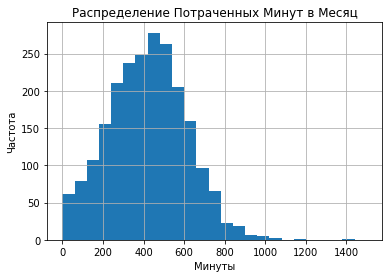

In [171]:
display(smart_users.total_min.describe())
smart_users.total_min.plot(kind = 'hist', range = (0,1500), bins = 25, grid = True)
plt.title('Распределение Потраченных Минут в Месяц')
plt.xlabel('Минуты')
plt.ylabel('Частота')
plt.show()

В минутах не очень наглядно выглядит, так что перерисую гистограмму в часах

count    2223.000000
mean        6.984383
std         3.155427
min         0.000000
25%         4.750000
50%         7.050000
75%         9.091667
max        23.916667
Name: total_hours, dtype: float64

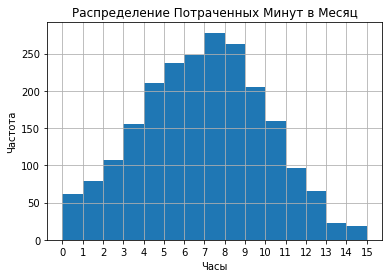

In [172]:
display(smart_users.total_hours.describe())
smart_users.total_hours.plot(kind = 'hist', range = (0,15), bins = 15, grid = True)
plt.title('Распределение Потраченных Минут в Месяц')
plt.xlabel('Часы')
plt.ylabel('Частота')
plt.xticks(range(0,16))
plt.show()

In [173]:
overdraft_part = len(smart_users.query('total_hours > (500 / 60)')) / len(smart_users)
print(f'Доля записей, превысивших лимит по звонкам: {overdraft_part:0.1%}')

Доля записей, превысивших лимит по звонкам: 33.8%


#### Вывод:

Из гистограммы видно, что для тарифа `smart` люди в среднем разговаривают около 7-8 часов в месяц. В тарифе предусмотрено 8.3 часа разговоров, так что большинство придерживаются этой нормы, но всё же треть датасета превысила лимит по звонкам.  
Распределение не симметричное, довольно размашистое. Меньше 7 часов разговаривают больше людей, чем больше 8 часов. 

### Распределение по сообщениям

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: total_sms, dtype: float64

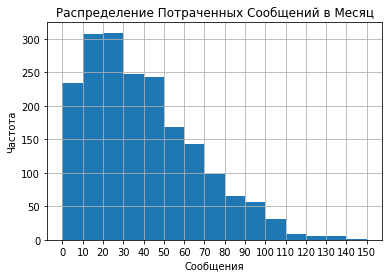

In [174]:
display(smart_users.total_sms.describe())
smart_users.total_sms.plot(kind = 'hist', range = (0,150), bins = 15, grid = True)
plt.title('Распределение Потраченных Сообщений в Месяц')
plt.xlabel('Сообщения')
plt.ylabel('Частота')
plt.xticks(range(0,151,10))
plt.show()

In [175]:
overdraft_part = len(smart_users.query('total_sms > 50')) / len(smart_users)
print(f'Доля записей, превысивших лимит по сообщениям: {overdraft_part:0.1%}')

Доля записей, превысивших лимит по сообщениям: 25.3%


#### Вывод:

По сообщениям видим, что в основном масса держится от 0 до 50 сообщений в месяц, а дальше идет резкий спад. Также 25.3% превысило лимит в 50 сообщений.

In [176]:
2230 - 1922

308

Видно что есть 308 записей, где пользователи вообще не использовали сообщения.

### Распределение по трафику интернета

count    2228.000000
mean       16.336176
std         5.737923
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: total_gb, dtype: float64

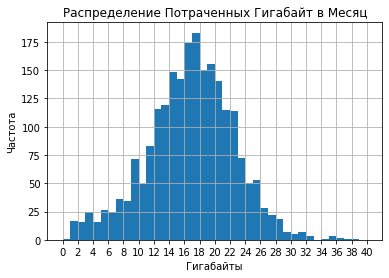

In [177]:
display(smart_users.total_gb.describe())
smart_users.total_gb.plot(kind = 'hist', range = (0,40), bins = 40, grid = True)
plt.title('Распределение Потраченных Гигабайт в Месяц')
plt.xlabel('Гигабайты')
plt.ylabel('Частота')
plt.xticks(range(0,41,2))
plt.show()

In [178]:
overdraft_part = len(smart_users.query('total_gb > 15')) / len(smart_users)
print(f'Доля записей, превысивших лимит по интернет трафику: {overdraft_part:0.1%}')

Доля записей, превысивших лимит по интернет трафику: 58.5%


#### Вывод:

Видим довольно симметричное распределение, где-то в среднем по 16-17 гигабайт в месяц тратят пользователи.
Ну и вот в этом месте данный тариф приносит огромную прибыль, так как больше половины датасета (58.5%) превышают лимит в 15 Гб

## Анализ тарифа `Ultra`

In [179]:
columns = ['total_min', 'total_sms', 'total_gb']
display(ultra_users[columns].describe().T)

,count,mean,std,min,25%,50%,75%,max
total_min,951.0,545.451104,306.925754,0.0,310.0,528.0,756.5,1673.0
total_sms,795.0,61.161006,45.931026,1.0,24.0,51.0,87.5,224.0
total_gb,975.0,19.694359,9.702924,0.0,12.0,19.0,27.0,49.0


### Распределение по минутам

In [180]:
ultra_users['total_hours'] = ultra_users.total_min / 60

count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: total_min, dtype: float64

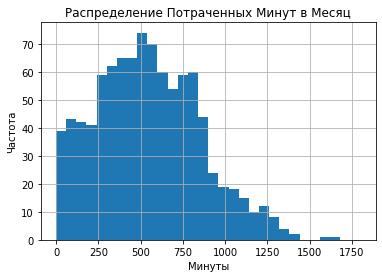

In [181]:
display(ultra_users.total_min.describe())
ultra_users.total_min.plot(kind = 'hist', range = (0,1800), bins = 30, grid = True)
plt.title('Распределение Потраченных Минут в Месяц')
plt.xlabel('Минуты')
plt.ylabel('Частота')
plt.show()

В минутах не очень наглядно выглядит, так что перерисую гистограмму в часах

count    951.000000
mean       9.090852
std        5.115429
min        0.000000
25%        5.166667
50%        8.800000
75%       12.608333
max       27.883333
Name: total_hours, dtype: float64

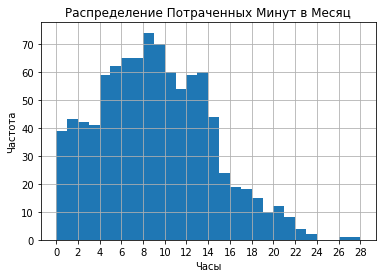

In [182]:
display(ultra_users.total_hours.describe())
ultra_users.total_hours.plot(kind = 'hist', range = (0,28), bins = 28, grid = True)
plt.title('Распределение Потраченных Минут в Месяц')
plt.xlabel('Часы')
plt.ylabel('Частота')
plt.xticks(range(0,29,2))
plt.show()

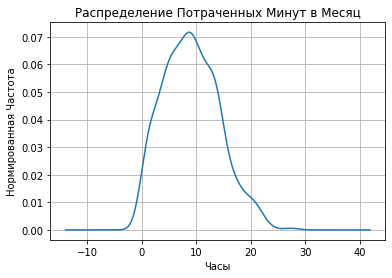

In [183]:
ultra_users.total_hours.plot(kind = 'kde', grid = True)
plt.title('Распределение Потраченных Минут в Месяц')
plt.xlabel('Часы')
plt.ylabel('Нормированная Частота')
# plt.xticks(range(0,29))
plt.show()

In [184]:
3000 / 60

50.0

In [185]:
overdraft_part = len(ultra_users.query('total_hours > (3000 / 60)')) / len(ultra_users)
print(f'Доля записей, превысивших лимит по звонкам: {overdraft_part:0.1%}')

Доля записей, превысивших лимит по звонкам: 0.0%


#### Вывод:

Из гистограммы видно, что для тарифа `ultra` люди в среднем разговаривают около 9-10 часов в месяц. Основная масса разговаривает от 4 до15 часов в месяц при этом тарифе.  

Но в тарифе предусмотрено 50 часов разговоров, так что никто этот предел в данной выборке превысить не смог.

### Распределение по сообщениям

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: total_sms, dtype: float64

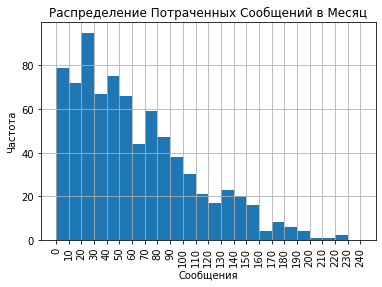

In [186]:
display(ultra_users.total_sms.describe())
ultra_users.total_sms.plot(kind = 'hist', range = (0,240), bins = 24, grid = True)
plt.title('Распределение Потраченных Сообщений в Месяц')
plt.xlabel('Сообщения')
plt.ylabel('Частота')
plt.xticks(range(0,241,10), rotation = 90)
plt.show()

In [187]:
overdraft_part = len(ultra_users.query('total_sms > 1000')) / len(ultra_users)
print(f'Доля записей, превысивших лимит по сообщениям: {overdraft_part:0.1%}')

Доля записей, превысивших лимит по сообщениям: 0.0%


#### Вывод:

По сообщениям видим, что в основном масса держится от 0 до 80 сообщений в месяц, а дальше идет резкий спад.

### Распределение по трафику интернета

count    975.000000
mean      19.694359
std        9.702924
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: total_gb, dtype: float64

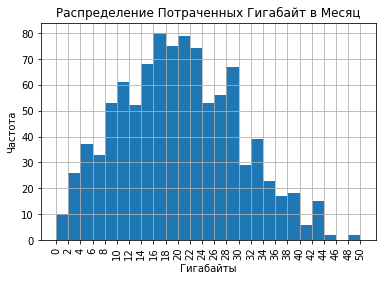

In [188]:
display(ultra_users.total_gb.describe())
ultra_users.total_gb.plot(kind = 'hist', range = (0,50), bins = 25, grid = True)
plt.title('Распределение Потраченных Гигабайт в Месяц')
plt.xlabel('Гигабайты')
plt.ylabel('Частота')
plt.xticks(range(0,51,2), rotation = 90)
plt.show()

In [189]:
overdraft_part = len(ultra_users.query('total_gb > 30')) / len(ultra_users)
print(f'Доля записей, превысивших лимит по интернет трафику: {overdraft_part:0.1%}')

Доля записей, превысивших лимит по интернет трафику: 13.6%


#### Вывод:

По гистограмме можно увидеть, что в среднем при тарифе `ultra` пользователи тратят около 19 Гб в месяц, что не так критично, так как этом тарифе предусмотрено 30 Гб трафика. Но всё же в данной выборке 13.6% пользователей превысили лимит в 30 Гб

# Шаг 4. Проверьте гипотезы

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;


* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

## Проверка первой гипотизы

Гипотиза: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

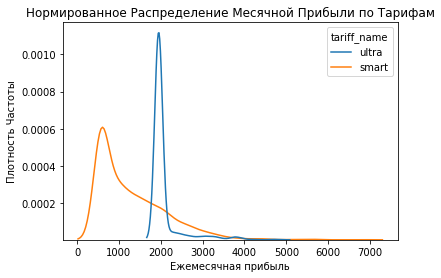

In [190]:
sns.kdeplot(data = report, x = 'month_revenue', hue = 'tariff_name')
plt.title('Нормированное Распределение Месячной Прибыли по Тарифам')
plt.xlabel('Ежемесячная прибыль')
plt.ylabel('Плотность Частоты')
plt.show()

Построил Нормированные графики распределения, ну и судя по виду, можно сказать, что действительно выручка для двух тарифов отличается.  
Для тарифа смарт, распределение сосредоточено в основном около 800 рублей и имеет длинющий хвост вправо.  
Для тарифа ультра, Имеется один чёткий пик в районе 2000 рублей и небольшой хвост справа.

Нулевая гипотеза: Средние двух генеральных совокупностей равны.

In [191]:
sample_1 = report.query('tariff_name == "smart"')["month_revenue"]
sample_2 = report.query('tariff_name == "ultra"')["month_revenue"]

results = st.ttest_ind(sample_1, sample_2)
print('p-значение: ', results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  8.081909555489933e-161
Отвергаем нулевую гипотезу


### Вывод:
Показали, что действительно выручки с разных тарифов сильно различаются.

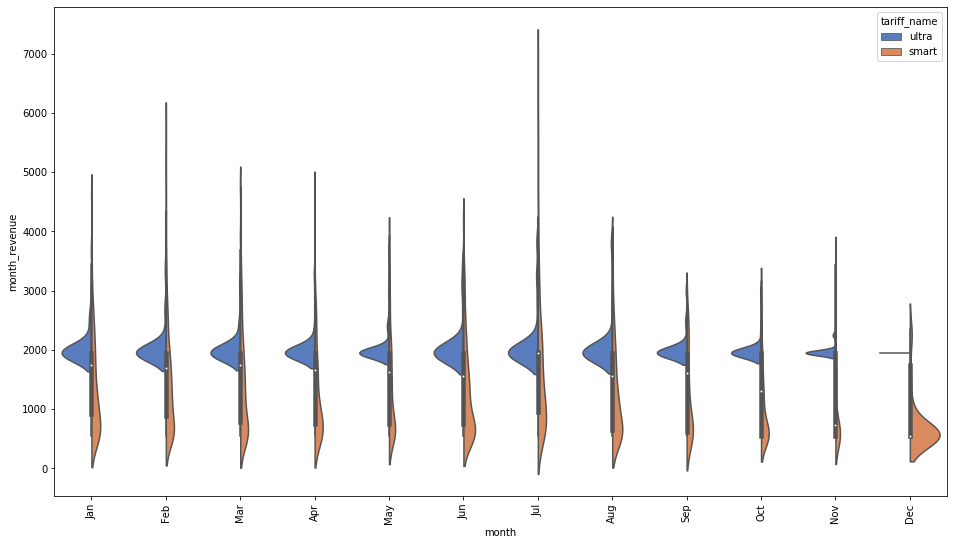

In [192]:
plt.figure(figsize = (16,9))
ax = sns.violinplot(x="month", y="month_revenue", hue="tariff_name",
                    data=report, palette="muted", split=True, grid = True)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.xticks(rotation = 90)
ax.set_xticklabels(month_names)
plt.show()

Хотел показать распределения выручки для двух тарифов по месяцам, но не очень наглядно получилось. Но видно, что в тарифе смарт очень расплывается месячная выручка с приблизительным центром около 700 рублей и дальше хвост в увеличение, А в тарифе ультра- стабильный купол около 2000, Что по сути и является месячной платой за тариф.

In [193]:
report.groupby('tariff_name').month_revenue.sum().reset_index().rename(columns = {'month_revenue': 'total_income'})

,tariff_name,total_income
0,smart,2875901.0
1,ultra,2041050.0


Привел здесь общую вырочку по тарифам, видно, что тариф смарт принес на 800 тысяч больше прибыли, что является довольно существенным. Но и пользователей с тарифом смарт на 200 больше.

## Проверка второй гипотизы

* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Теперь предстоит сделать табличку с категориями пользователей по городу "Москва" и "Другой"

Посмотрим сколько у нас пользователей из Москвы

In [194]:
print(sorted(users.city.unique()))

['Архангельск', 'Астрахань', 'Балашиха', 'Барнаул', 'Белгород', 'Брянск', 'Владивосток', 'Владикавказ', 'Владимир', 'Волгоград', 'Волжский', 'Вологда', 'Воронеж', 'Грозный', 'Екатеринбург', 'Иваново', 'Ижевск', 'Иркутск', 'Казань', 'Калининград', 'Калуга', 'Кемерово', 'Киров', 'Кострома', 'Краснодар', 'Красноярск', 'Курган', 'Курск', 'Липецк', 'Магнитогорск', 'Махачкала', 'Москва', 'Мурманск', 'Набережные Челны', 'Нижневартовск', 'Нижний Новгород', 'Нижний Тагил', 'Новокузнецк', 'Новороссийск', 'Новосибирск', 'Омск', 'Оренбург', 'Орёл', 'Пенза', 'Пермь', 'Петрозаводск', 'Подольск', 'Ростов-на-Дону', 'Рязань', 'Самара', 'Санкт-Петербург', 'Саранск', 'Саратов', 'Севастополь', 'Смоленск', 'Сочи', 'Ставрополь', 'Стерлитамак', 'Сургут', 'Тамбов', 'Тверь', 'Тольятти', 'Томск', 'Тула', 'Тюмень', 'Улан-Удэ', 'Ульяновск', 'Уфа', 'Хабаровск', 'Химки', 'Чебоксары', 'Челябинск', 'Череповец', 'Чита', 'Якутск', 'Ярославль']


Ну похоже разношорстности в данных нет, так что просто начнем с создания сводной таблички.

In [195]:
city_df = report[['user_id','tariff_name','month_revenue']].merge(users[['user_id','city']], how = 'left', on = 'user_id')

In [196]:
print(len(city_df))
city_df.head(10)

3216


,user_id,tariff_name,month_revenue,city
0,1000,ultra,1950.0,Краснодар
1,1000,ultra,1950.0,Краснодар
2,1000,ultra,1950.0,Краснодар
3,1000,ultra,1950.0,Краснодар
4,1000,ultra,1950.0,Краснодар
5,1000,ultra,1950.0,Краснодар
6,1000,ultra,1950.0,Краснодар
7,1000,ultra,1950.0,Краснодар
8,1001,smart,1150.0,Москва
9,1001,smart,550.0,Москва


In [197]:
def city_category(row):
    """
    Функция возвращает категорию города: либо Москва, либо Другой.
    """
    if row == 'Москва':
        return 'Москва'
    return 'Другой'

In [198]:
city_df['city_cat'] = city_df.city.apply(city_category)
city_df.sample(10)

,user_id,tariff_name,month_revenue,city,city_cat
2166,1340,smart,1350.0,Пенза,Другой
142,1020,smart,550.0,Чита,Другой
2438,1382,ultra,1950.0,Самара,Другой
1340,1209,smart,1219.0,Омск,Другой
1229,1189,smart,1576.0,Санкт-Петербург,Другой
124,1017,smart,1750.0,Краснодар,Другой
1856,1292,ultra,1950.0,Красноярск,Другой
706,1110,smart,1150.0,Петрозаводск,Другой
343,1055,smart,1150.0,Казань,Другой
1344,1209,smart,1380.0,Омск,Другой


In [199]:
city_df.city_cat.value_counts()

Другой    2605
Москва     611
Name: city_cat, dtype: int64

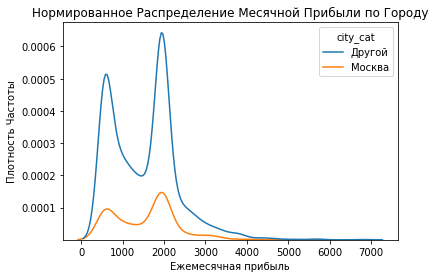

In [200]:
sns.kdeplot(data = city_df, x = 'month_revenue', hue = 'city_cat')
plt.title('Нормированное Распределение Месячной Прибыли по Городу')
plt.xlabel('Ежемесячная прибыль')
plt.ylabel('Плотность Частоты')
plt.show()

Нулевая Гипотиза: Средние двух генеральных совокупностей равны

In [201]:
sample_1 = city_df.query('city_cat == "Москва"')["month_revenue"]
sample_2 = city_df.query('city_cat == "Другой"')["month_revenue"]

results = st.ttest_ind(sample_1, sample_2)
print('p-значение: ', results.pvalue)

alpha = 0.05

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5400751614511182
Не получилось отвергнуть нулевую гипотезу


### Вывод:

Отвергнуть гипотизу о том, что выручки одинаковы мы не смогли. Так что теперь нужно придумать другой способ показать различие.  
Но по распределению видно, что в категории Другой город, просто больше пользователей, ну а распределения очень и очень похожи. Видно два пика от двух тарифов. 

# Шаг 5. Напишите общий вывод

В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

В самом начале в нашем распоряжении 5 табличек: `Users`, `calls`, `internet`, `messages`, `tariffs`. Каждая описывает данные по пользователям, по звонкам, по интернету, по сообщениям, по тарифам соответственно.  
В этих таблицах заменили все даты из формата `object` на `datetime`.  
В табличке `internet` был лишний столбец `unnamed0`, который успешно удалили.  
В данных по звонкам были звонки с нулевой длительностью, которые я считал пропущенными. Я их оставил в датасете и на всякий случай посчитал их количество в таблице `df1`  


Используя данные таблиц были составлены 3 таблицы с расчетом количества звонков и потраченных минут, сообщений, интернет трафика `df1`, `df2`, `df3` 

Дальше была созданна общая табличка `report` с подсчетом помесячной выручки по каждому пользователю.


Был проведен анализ по каждому тарифу и приведины распределения для звонков, сообщений и интернета. 

Тариф `Smart`:

*  Для тарифа smart люди в среднем разговаривают около 7-8 часов в месяц. В тарифе предусмотрено 8.3 часа разговоров, так что большинство придерживаются этой нормы, но всё же 33.8% датасета превысила лимит по звонкам.  

* По сообщениям видим, что в основном масса держится от 0 до 50 сообщений в месяц, а дальше идет резкий спад. Также 25.3% превысило лимит в 50 сообщений.

* По интернету где-то в среднем по 16-17 гигабайт в месяц тратят пользователи. Ну и вот в этом месте данный тариф приносит огромную прибыль, так как больше половины датасета (58.5%) превышают лимит в 15 Гб

Тариф `Ultra`:

* По звонкам превышений не наблюдается

* По сообщениям превышений также не наблюдается 

* По гистограмме можно увидеть, что в среднем при тарифе ultra пользователи тратят около 19 Гб в месяц, что не так критично, так как в этом тарифе предусмотрено 30 Гб трафика. Но всё же в данной выборке 13.6% записей превысили лимит в 30 Гб

Также были проверены 2 гипотизы:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;  
Данная гипотиза подтвердилась, выручки действительно различаются.


* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;  
Данная гипотиза не подтвердилась, распределение для Москвы и других городов выглядят практически идентичными.

Необходимо сделать вывод о том, какой тариф **лучше**?  

С точки зрения компании:  

Больше пользователей выбирают тариф смарт, к тому же по многим параметрам переплачивают пользователи за превышения лимитов. К тому же по данной выборке данный тариф за год принес на 800 тысяч рублей больше, чем тариф ультра.  
Поэтому, на мой взгляд, тариф смарт лучше подходит для компании.

С точки зрения пользователя:  

Если укладываешься по звонкам и сообщениям и используешь интернета меньше 22 Гб, то это определенно нужно выбирать тариф смарт. Будет дешевле выходить в месяц, чем за тариф ультра.  
Если интернета выходит больше 22 Гб, то нужно брать тариф ультра, где включено 30 Гб интернета. Ну и при этом чтобы по звонкам и сообщениям переплатить нужно очень постараться.